# Kapitel 9 - XGBoost & Decision trees

## 9.1. Kapitelübersicht <a class="anchor" id="9-1"/>

Bis jetzt hatten wir probabilistische Klassifizierungsverfahren wie Logistic Regression und Naive Bayes sowie die Kernel-Methode SVM kennengelernt. Eine letzte wichtige Art von Klassifizierungsmethoden sind die sogenannten <b>Decision trees</b> (= Entscheidungsbäume), welche mithilfe von Entscheidungsregeln klassifizieren. Wir werden in diesem Kapitel die Technik <b>Ensemble Learning</b> kennenlernen, welche mehrere Decision trees miteinander kombiniert, um bessere Klassifizierungsverfahren zu schaffen. Dabei werden wir besonders auf die <b>Boosting</b> Technik und das darauf aufbauende Verfahren <b>Gradient Boosting Machines</b> eingehen. Hauptthema dieses Kapitel soll jedoch <b>XGBoost</b> sein, eine optimierte Version der Gradient Boosting Machines und aktuell eines der beliebtesten Machine Learning Klassifizierungsverfahren. XGBoost ist der neuste aber auch der wohl komplizierteste Machine Learning Algorithmus, den wir in dieser Tutorialreihe behandeln werden. Um sein volles Potential ausschöpfen zu können, muss eine Reihe an Hyperparameteroptimierungen durchgeführt werden, die wir in diesem Ausmaß noch nicht so ausführlich behandelt haben. Dies soll einen Einblick in die tatsächliche Arbeit eines Data Scientist geben.

<b>Abschnittsübersicht</b><br>

[9.1. Kapitelübersicht](#9-1)<br>
[9.2. Decision trees](#9-2)<br>
[9.3. Ensemble learning](#9-3)<br>
[9.4. Gradient Boosting](#9-4)<br>
[9.5. XGBoost](#9-5)<br>
[9.5.1. Vorteile von XGBoost](#9-5-1)<br>
[9.5.2. Implementierung von XGBoost in Scikit learn](#9-5-2)<br>
[9.5.3. Hyperparameteroptimierung von XGBoost](#9-5-3)<br>
[9.5.4. Das finale Modell](#9-5-4)<br>
[9.6. Mögliche Fehler](#9-6)<br>

Am Ende dieses Kapitel werden wir folgende Themen behandelt und/oder vertieft haben:
- Decision trees
- Implementierung von Decision trees in Scikit learn
- Tree Pruning
- Ensemble Learning
- Bagging
- Boosting
- Gradient Boosting
- Implementierung von Gradient Boosting in Scikit learn
- XGBoost Paper
- XGBoosts Vorteile gegenüber anderen Gradient Boosting Machines
- 

- Early Stopping
- Ausführliche Hyperparameteroptimierung


## 9.2. Decision trees <a class="anchor" id="9-2"/>

<b>Decision trees</b> (deutsch: Entscheidungsbäume) sind geordnete und gerichtete Bäume und dienen der Darstellung von Entscheidungsregeln. Oft werden diese Verfahren auch als <b>CART</b> (= Classification and Regression Trees) bezeichnet, welches ein Algorithmus für decision trees für Klassifikation und Regression ist.

<div class="alert alert-info">
<b>Exkurs:</b> Baum (Datenstruktur)
    
<b>Bäume</b> sind Datenstrukturen, mit der sich hierarchische Strukturen abbilden lassen. Sie besitzen <b>Knoten</b> (englisch: nodes) und <b>Kanten</b> (englisch: edges). Der erste Knoten nennt sich <b>Wurzel</b> (englisch: root). In dem folgenden Beispiel ist "CD" die Wurzel. Von ihr aus gehen Kanten zu anderen Knoten wie "Rock", "Folk", "Jazz" und "Klassik". Untergeordnete Knoten nennt man auch <b>Kindknoten</b> (englisch: child nodes) und übergeordnete Knoten <b>Elternknoten</b> (englisch: parent nodes). "Rock", "Folk", "Jazz" und "Klassik" sind die Kindknoten von "CD" und "CD" ist der Elternknoten von "Rock", "Folk", "Jazz" und "Klassik". Die Kindknoten von "Rock" nennt man <b>Blätter</b> (englisch: leaves), da diese selbst keine Kindknoten besitzen.<br>

<img src="https://wvsg.schulen2.regensburg.de/joomla/images/Faecher/Informatik/Informatik_11/Bilder/2_1_Von_der_Liste_zum_Baum/baum_allg.png" alt="Tree" width="450px" align="center"/>

</div>

Der Klassifikationsvorgang von Decision trees lässt sich am besten an einem graphischen Beispiel erläutern:

<img src="tutorialdata/img/decision_tree_german.png" alt="Decision Tree" width="350px" align="left"/>

Zu sehen ist ein Binärbaum. Jeder Wurzelknoten repräsentiert eine Eingabevariable $x$ und einen Punkt, an der sich die Variable teilt. Die Blattknoten des Baums enthalten eine Ausgabevariable $y$, die zur Vorhersage verwendet wird. Die möglichen Ausgaben sind hier "Erwachsener", "Erwachsener", "Kind". In diesem Beispiel wird anhand der Körpergröße und des Gewichts bestimmt, ob eine Person ein Kind oder ein Erwachsener ist. Wir können diesen Baum auch als Regeln modellieren:<br>
```
If Größe > 180cm Then Erwachsener
If Größe <= 180cm AND Gewicht > 70kg Then Erwachsener
If Größe <= 180cm AND Gewicht <= 70kg Then Kind
```

Vorhersagen können somit relativ einfach getroffen werden. Für den Input wird vom Wurzelknoten aus gesehen der Baum durchlaufen und der Blattknoten als Vorhersage ausgegeben. Dies könnte so aussehen:

```
Größe > 180cm: False
Gewicht > 70 kg: False
Therefore: Kind
```

Die Schwierigkeit bei der Erstellung eines Decision trees ist die Modellierung. Ein Binärbaum wie aus dem Beispiel ist eigentlich ein aufgeteilter Eingaberaum. Jede Eingabevariable $x$ ist eine Dimension des x-dimensionalen Raums. 
Der Decision tree teilt diesen Eingaberaum in Rechtecke auf, neue Daten werden durch den Baum gefiltert und in einem der Rechtecke "deponiert". Der Ausgabewert eines Rechtecks ist die Vorhersage des Verfahrens. Die Aufteilung des Eingabereaums erfolgt <b>greedy</b> (deutsch: gierig), d.h. es werden immer die besten Punkte gesucht, an denen der Raum aufgeteilt werden kann. Mathematisch geschieht dies durch eine <b>Cost Function</b>[<sup>1</sup>](#fn1), die durch Ausprobieren und Testen von verschiedenen Punkten und Aufteilungen nach und nach die besten Splitpunkte findet. Bei der Klassifikation wird diese Cost Function durch die <b>Gini Index Funktion</b> repräsentiert. Diese wählt die Entscheidungsregeln aus, bei der die Kindknoten möglichst <u>rein</u>[<sup>2</sup>](#fn2) werden.<br>

Dieser ganze Split-Vorgang erfolgt rekursiv und wird durch ein <b>Stopkriterium</b> beendet. Damit kann die Laufzeit verringert und die Performance des Verfahrens verbessert werden. Eine weitere Methode, um die Perfomance von Decision trees zu verbessern, ist <b>Tree Pruning</b> (deutsch: Zurechtstutzen von Bäumen). Wie komplex ein Decision tree ist, bestimmt die Anzahl der Aufteilungen (englisch: Splits) des Baumes. Je mehr Splits ein Decision tree hat, desto komplexer ist er. Simplere Decision trees werden jedoch bevorzugt, da sie einfacher zu verstehen und die Chance, dass es zu Overfitting kommt, geringer. Verschiedene Pruning Techniken werden <a href="https://de.wikipedia.org/wiki/Pruning">hier</a> gut erklärt. Eine einfache Pruning-Methode ist es, jeden Blattknoten (leaf) in einem Decision tree zu betrachten und mithilfe eines Testdatensatzes zu bewerten, wie hoch die Auswirkung auf die Cost Function wäre, wenn der Blattknoten entfernt werden würde. Verringert sich die Cost Function, wird der Blattknoten dauerhaft aus dem Baum entfernt. Verändert sich die Cost Function nach einiger Zeit nicht mehr, wird das Pruning beendet.


<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">1</sup> &nbsp; Cost Function werden uns später bei Neuronalen Netzen im Bereich des Deep Learning erneut begegnen (siehe Kapitel 11).</span><br>
<span id="fn2" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">2</sup> &nbsp; Was <b>Reinheit</b> (= purity) bedeutet, wird bei dieser <a href="https://stats.stackexchange.com/questions/220321/what-is-node-impurity-purity-in-decision-trees-in-plain-english-why-do-we-need">Antwort</a> bei StackExchange erklärt.</span>

#### Implementierung in Scikit learn

Die Implementierung in Scikit learn unterscheidet sich nicht groß von den Implementierungen der anderen Klassifizierungsverfahren.

#### Korpus laden

In [1]:
import pandas as pd
corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv", index_col=0)

#### Aufteilung in Trainings- und Testdatensätze

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

import numpy as np
import matplotlib.pyplot as plt
import scipy

labels = LabelEncoder().fit_transform(corpus["category"])
vector  = TfidfVectorizer().fit_transform(corpus["text"])

X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    train_size=0.8,
                                                    random_state=42)

#### DecisionTreeClassifier

In [26]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree
dt_classifier = DecisionTreeClassifier()
dt = dt_classifier.fit(X_train, y_train)

# cross validation des Trainingsdatensatzes
dt_scores = cross_val_score(dt_classifier, vector, labels, cv=3)
dt_mean = np.mean(dt_scores)

print("Der Mittelwert der cross validation bei der  Klassifizierung " 
      + f" mit Decision Tree ist {str(np.around(dt_mean, decimals=3))}."
      + "\n")


# F1-score des Testdatensatzes
y_pred = dt_classifier.predict(X_test)
dt_f1 = f1_score(y_test, y_pred, average="micro")

print("Der F1-score für die Klassifizierung mit Decision Tree ist "
      + f"{str(np.around(dt_f1, decimals=3))}.")

Der Mittelwert der cross validation bei der  Klassifizierung  mit Decision Tree ist 0.668.

Der F1-score für die Klassifizierung mit Decision Tree ist 0.717.


Die Werte für die Decision trees sind nicht besonders gut. Anstatt nun aber zu versuchen, diese Werte durch gezieltes Parametertuning zu verbessern, werden wir uns stattdessen effektivere Decision tree Verfahren anschauen.

## 9.3. Ensembling learning <a class="anchor" id="9-3"/>

<b>Ensemble learning</b> sind Methoden des Machine Learning, bei denen Modelle nicht einzeln trainiert und dann verglichen, sondern die Voraussagen mehrerer Modelle kombiniert werden, um die allgemeine Performance zu erhöhen. Das wichtigste Einsatzgebiete für Ensemble learning sind die <b>Decision trees</b>. Zwei Techniken des Ensemble learning werden sehr häufig bei den Decision trees angewendet: <b>Bagging</b> und <b>Boosting</b>.

#### Bagging

Beim <b>Bagging</b> (oder auch <b>Bootstrapping</b>) wird der Datensatz in mehrere Teildatensätze unterteilt. Auf jedem Teildatensatz wird nun parallel ein Modell trainiert.  Die finale Vorhersage wird aus allen Vorhersagen der Modelle bestimmt.

#### Boosting

Beim <b>Boosting</b> werden viele schwache Classifiers zu einem starken Classifier vereinigt. Anders als beim Bagging funktioniert dies nicht parallel, sondern nacheinander. Jedes folgende Modell versucht die Fehler der vorangegangenen Modelle zu verbessern. Sie sind abhängig von den vorherigen Modellen. Der Vorgang funktioniert folgendermaßen:

1. Ein Teildatensatz wird aus dem originalen Datensatz erstellt.
2. Alle Datenpunkte/Features erhalten bei der Initialisierung die gleichen Gewichte.
3. Ein Basismodell wird auf Basis des Teildatensatzes erstellt.
4. Dieses Modell wird benutzt, um Vorhersagen für den gesamten Datensatz zu bestimmen.
5. Fehler werden berechnet, indem die aktuellen Werte/Labels mit den vorhergesagten Werten/Labels verglichen werden.
6. Die Beobachtungen, die inkorrekt vorhergesagt wurden, bekommen höhere Gewichte.
7. Ein weiteres Modell wird erstellt, welches Vorhersagen auf den Datensatz trifft. Es versucht die Fehler vom vorherigen Modell, die höher gewichtet wurden, zu korrigieren.
8. Gleichzeitig werden mehrere Modelle erstellt, die die Fehler des vorherigen Modells korrigieren.
9. Das finale Modell (strong learner) ist der gewichtete Mittelwert aller Modelle (weak learners). Der Boosting Algorithmus kombiniert also weak learners, um einen strong learner zu erschaffen.


#### Bagging oder Boosting?

Beide Techniken wurden etwa zeitgleich entwickelt. Boosting ist mächtiger als Bagging, erfordert jedoch auch mehr Aufwand und Sorgfalt bei der Benutzung. Zu beiden Techniken gibt es verschiedene Varianten des DecisionTreeClassifiers in Scikit learn implementiert. Das populärste Verfahren für Bagging ist <b>Random Forest</b>, welches in diesem Tutorial jedoch nicht behandelt wird. Wir konzentrieren uns auf die Boosting-Implementierung <b>Gradient Boosting</b> und den verbesserten Nachfolger <b>XGBoost</b>. Letzteres Verfahren ist wohl das aktuell beste und beliebteste Machine Learning Klassifizierungsverfahren.

## 9.4. Gradient Boosting <a class="anchor" id="9-4"/>

<b>Gradient Boosting</b> ist ein Klassifizierungsverfahren, welches auf der Ensemble Learning Technik <b>Boosting</b> beruht. Decision trees werden als base learner eingesetzt, jeder folgende Decision tree basiert auf den Fehlern der vorherigen Bäume. Gradient Boosting ist in Scikit learn als `GradientBoostingClassifier` implementiert. Die Implementierung funktioniert dabei wie bei den anderen Klassifizierungsverfahren.

In [149]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting
gb_classifier = GradientBoostingClassifier()
gb = gb_classifier.fit(X_train, y_train)

# cross validation des Trainingsdatensatzes
gb_scores = cross_val_score(gb_classifier, vector, labels, cv=3)
gb_mean = np.mean(gb_scores)

print("Der Mittelwert der cross validation bei der Klassifizierung " 
      + f" mit Gradient Boosting ist {str(np.around(gb_mean, decimals=3))}."
      + "\n")


# F1-score des Testdatensatzes
y_pred = gb_classifier.predict(X_test)
gb_f1 = f1_score(y_test, y_pred, average="micro")

print("Der F1-score für die Klassifizierung mit Gradient Boosting ist "
      + f"{str(np.around(gb_f1, decimals=3))}.")

Der Mittelwert der cross validation bei der Klassifizierung  mit Gradient Boosting ist 0.848.

Der F1-score für die Klassifizierung mit Gradient Boosting ist 0.867.
CPU times: user 2h 48min 41s, sys: 1.57 s, total: 2h 48min 42s
Wall time: 2h 48min 40s


Die Ausführung dauert sehr lange (hier fast 3 Stunden). Scikit learn empfiehlt in seinem <a href="https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting">User-Guide</a>, für Multiclass Klassifizerung lieber <b>Random Forest</b> zu benutzen.<br>

Die cross-validation und der F1-score sind schon besser als bei den Decision trees, jedoch nicht besser als Logistic Regression oder SVM. Anstatt Gradient Boosting zu optimieren, werden wir uns die optimierte und neuere Variante <b>XGBoost</b> im nächsten Abschnitt genauer anschauen.

## 9.5. XGBoost <a class="anchor" id="9-5"/>

<div class="alert alert-warning">
<b>Aufgabe:</b> XGBoost Paper lesen
  
Machine Learning ist ein Feld ist, in dem viel geforscht wird und es ständig neue Errungenschaften gibt. Diese Errungenschaften werden in Form von wissenschaftlichen Papers veröffentlicht. Implementierungen wie in Scikit learn erfolgen erst Jahre später, im Falle von XGBoost steht eine direkte Implementierung wie von Verfahren wie Naive Bayes oder Logistic Regression noch aus (Stand: 05.09.2019), jedoch gibt es einen <a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn">Scikit learn Wrapper</a>. Um die aktuellesten Verfahren nutzen zu können, müssen neue Machine Learning Verfahren entweder selbst implementiert oder auf noch nicht durchweg ausgereifte Implementierungen zurückgegriffen werden. Neben fehlenden Implementierungen ist ein weiteres Problem das Fehlen von Guides oder Tutorials. Deshalb ist das Lesen von wissenschaftlichen Papers und der Umgang mit diesen eine Fähigkeit, die für eine Arbeit im Bereich des Machine Learnings unabdingbar ist.<br>
  
Lesen Sie zum Einstieg das <a href="https://arxiv.org/abs/1603.02754">Paper</a> zu XGBoost. Versuchen Sie, wichtige Errungenschaften, Details und Formeln nachzuvollziehen und zu verstehen. Machen Sie sich Notizen und schlagen Sie Unbekanntes nach. Lassen Sie sich nicht von den Formeln abschrecken, versuchen Sie nicht, jede kleine Rechnung, sondern die Inuition hintern den Formeln und ihren Nutzen zu verstehen. Der Vorteil bei diesem Paper ist, dass es sehr verständliche visuelle Beispiele bietet. Nutzen Sie diese als Hilfe für die verschiedenen vorgestellten Algorithmen. Versuchen Sie nicht, beim ersten Durchlesen alles zu verstehen, sondern lesen Sie das Paper mehrmals. Überlegen Sie sich, worin Unterschied zum Gradient Boosting liegen und was weitere Neuerungen von XGBoost sind. 

</div>

### 9.5.1. Vorteile von XGBoost <a class="anchor" id="9-5-1"/>

<b>XGBoost</b> (= E<b>x</b>treme <b>G</b>radient <b>Boost</b>ing) ist eine optimierte Implementierung von Gradient Boosting Decision Trees. Bekanntheit erlangte XGBoost durch dein Einsatz bei Machine-Learning-Wettbewerben wie <i>Kaggle</i>, wo es große Erfolge und Siege erzielen konnte. Dies liegt an einigen Vorteilen von XGBoost gegenüber den Gradient Boosting Decision Trees:
- **Parallelverarbeitung**: XGBoost erlaubt Parallelverarbeitung (englisch: parallel processing) und ist somit um ein einiges schneller als Gradient Boosting Machines.
- **Hohe Flexibilität**: XGBoost kann sehr gut durch Benutzer optimiert werden und erlaubt es dem Nutzer, eigene Evaluationskriterien zu nutzen. 
- **Regularisierung**: XGBoost unterstützt eine eingebaute Regularisierung, welches gegen Overfitting hilft.
- **Eingebaute Cross Validation**: XGBoost erlaubt es dem Nutzer, bei jeder Boosting-Iteration eine Cross Validation durchzuführen.
- **Tree Pruning**: TODO

TODO

- Schwäche von XGBoost: https://github.com/dmlc/xgboost/issues/4079
- GBM vs. XGBoost: https://datascience.stackexchange.com/questions/16904/gbm-vs-xgboost-key-differences

### 9.5.2. Implementierung von XGBoost in Scikit learn <a class="anchor" id="9-5-2"/>

Zunächst vektorisieren, encoden und splitten wir das Korpus wie gewohnt. Den XGBoostClassifier implementieren wir hier mit `xgboost.sklearn`, um den Scikit learn Wrapper nutzen zu können.

In [36]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split


vectorizer = TfidfVectorizer()

vector  = vectorizer.fit_transform(corpus["text"])
labels = LabelEncoder().fit_transform(corpus["category"])

X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    train_size=0.8,
                                                    shuffle=True,
                                                    random_state=42)

Nun wollen wir unseren Trainingsdatensatz noch einmal in einen Validierungsdatensatz aufteilen. Der <b>Validierungsdatensatz</b> wird zur Evaluierung des Klassifikationsmodells während der Anpassung der Parameter benutzt (siehe Kapitel 5). Er zeigt uns an, ob unser Klassifizierungsverfahren <b>overfittet</b>. Dazu gleich mehr.

In [39]:
X_train_small = X_train[:3600]
y_train_small = y_train[:3600]
X_val = X_train[3600:]
y_val = y_train[3600:]

Unser Validierungs- und Testdatensatz besteht aus jeweils 1200 Artikeln. Wir haben hier einen 60/20/20 Split (Train/Val/Test).

In [71]:
print(X_train_small.shape)
print(y_train_small.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(3600, 281396)
(3600,)
(1200, 281396)
(1200,)
(1200, 281396)
(1200,)


Als nächstes bestimmen wir eine Evaluierungsset `eval__set`, der die Trainings- und Validierungsdatensätze beinhaltet. Dieses übergeben wir unserem XGBoost-Classifier.
Als Evaluationsmaß nutzen wir hier `merror` (`error` für Multiclass Klassifizierung). Er wird folgendermaßen berechnet:<br>

$ \text{merror}\ =\ \frac{\text{Anzahl der falsch zugewiesenen Labels}}{\text{Anzahl aller Labels}} $ <br>

Er gibt also den Anteil der falsch zugewiesenen Kategorien an. Im Trainingsprozess möchten wir, dass dieser Wert kontinuierlich sinkt, da wir somit erkennen, dass Modell[<sup>1</sup>](#fn1) sich beim Lernen verbessert und weniger Fehler macht.<br>

Ein weiteres Evalutionsmaß, welches wir nutzen, ist `mlogloss` (`logloss` für Multiclass Klassifizierung). Es gibt an, wie hoch der <b>Loss score</b> der <b>Cost Function</b> nach jedem Durchgang ist. Dieser Loss score gibt an, wie groß der Unterschied vom vorausgesagten Label zum tatsächlichen Label war.[<sup>2</sup>](#fn2)

<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">1</sup> &nbsp; Im Folgenden werden wir unseren Classifier <b>Modell</b> nennen.</span><br>
<span id="fn2" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">2</sup> &nbsp; Loss scores und Cost Functions werden in Kapitel 11 noch genauer erklärt und eigenständig implementiert.</span>

In [73]:
eval_set = [(X_train_small, y_train_small), (X_val, y_val)]
eval_metric = ["merror", "mlogloss"]

Nun zu unserem Modell. Wir haben hier eine Reihe von Parametern übergeben. Die Wahl der Parameter ist bei XGBoost sehr wichtig und Veränderungen können massive Veränderungen bei der Laufzeit und der Genauigkeit des Modells bewirken.<br>

**`objective`**: Hier geben wir unsere Art des Klassifizierungsverfahrens an. Für die Multiclass Klassifizierung stehen "multi:softmax" und "multi:softprob" zur Verfügung. Wir benutzen "multi:softmax", welches die <b>Softmax-Funktion</b>  benutzt (siehe Kapitel 6.3.3). Um "multi:softmax" nutzen zu können, müssen wir den Parameter `num_classes` bestimmen.<br>

**`num_classes`**: Gibt bei einer Multiclass Klassifizierung die Anzahl der verschiedenen Klassen an. Wir könnten hier entweder "30" angeben oder mithilfe von `len(np.unique(labels))` automatisch die unterschiedliche Anzahl der Labels angeben. Letzters ist dynamischer, wenn man vorhat, das Korpus für Experimente zu verkleineren.<br>

**`learning_rate`**: Die Lernrate, die das Modell robuster macht, indem es die Gewichte bei jedem Trainingsschritt schrumpfen lässt. <b>Achtung</b>: Bei der Python-Implementierung von XGBoost ohne den Scikit learn Wrapper heißt dieser Parameter `eta`.<br>

**`n_estimators`**: XGBoost ist ein Boosting-Verfahren, welches sich wiederum der Ensemble Learning Technik bedient (siehe Abschnitt 9.3). Dabei werden verschiedene Decision Tree Klassifizierungsverfahren miteinander kombiniert. Mithilfe der Boosting-Technik übernimmt das aktuelle Modell die Fehler des vorhergegangenen Modells und versucht, diese zu verbessern. Für jedes Modell wird das angegebene Evaluierungsmaß ausgegeben. `n_estimators` bezeichnet somit die Anzahl der Durchgänge.[<sup>3</sup>](#fn3) Umso größer wir den Wert für `n_estimators` setzen, umso länger dauert der Trainingsdurchlauf, doch umso besser kann auch das Modell werden. <b>Vorsicht</b>: Ab einer bestimmten Anzahl kann das Modell zu overfitten beginnen. Ein höherer `n_estimators` Wert bedeutet nicht zwangsweise ein besseres Modell.<br>

**`max_depth`**: Maximale Tiefe eines Baumes. Eine höhere Tiefe erlaubt dem Modell, spezifische Beziehungen auf Basis eines bestimmten Beispiels zu lernen. Je niedriger der Wert ist, umso schneller ist das Modell. Je höher der Wert ist, umso langsamer ist das Modell, umso mehr Beziehungen kann es jedoch auch lernen.<br>

**`colsample_bytree`**: Bestimmt die Anzahl der columns (deutsch: Spalten) eines jeden Baumes. Die Column Blocks sind wichtig für das parellel ausführbare Lernen und wird im XGBoost-Paper in Kapitel 4.1 beschrieben. Um zu vermeiden, dass einige columns für die Vorhersage zu wichtig werden, wird ein Anteil der Spalten herausgenommen.<br>

**`samples`**: Funktioniert wie `colsample_bytree`, nur Anstatt für die columns für die <b>rows</b> (deutsch: Reihen).<br>

**`gamma`**: Regularisierungparameter. <br>

**`verbosity`**: Verantwortlich für die Ausführlichkeit der Logging-Informationen. Kann Werte zwischen 0 und 3 annehmen. "0" steht dabei für keine Logging-Informationen (silent),  "1" für "warning", "2" für "info" und "3" für "debug". Die sinnvollste Repräsentation ist hier "0" oder "1", da ansonsten zu viel Output generiert werden kann.<br>

**`n_jobs`**: Gibt die Anzahl der CPU-Kerne an, die für eine parallele Ausführung benutzt werden sollen. Sollte der Computer während des Trainings keine anderen großen Prozesse laufen lassen, kann man für ein schnelleres Training alle CPU-Kerne verwenden. Ich würde aber empfehlen, ein oder zwei Kerne dem Classifier vorzuenthalten.<br>

**`random_seed`**: Gleicher Effekt wie bei `train_test_split` von Scikit learn (siehe Kapitel 5).

<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">3</sup> &nbsp; Dies funktioniert ähnlich wie die <b>Epochen</b> der Deep-Learning-Bibliothek <b>Keras</b>, welche wir uns in Kapitel 12 genauer anschauen werden.</span><br>

Wir setzen hier zu Beginn `n_estimators = 20` für einen schnellen Durchlauf des Classifiers. Laut diesem <a href="https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e">Blogpost</a> scheint "100" ein guter Wert für sehr große Datensätze und "1000" ein guter Wert für mittelgroße bis kleine Datensätze zu sein. `max_depth` setzen wir ebenfalls nuur auf "2" für Demonstrationszwecke. Gute Werte scheinen im Bereich "3-10" zu liegen. Werte zwischen "0.3" und "0.8" sollte für `colsample_bytree` gewählt werden, wenn die Bäume viele columns haben und Werte zwischen "0.8" und "1" für Bäume mit wenigen columns. `subsample` sollte nur Werte zwischen "0.8" und "1" annehmen, da der Verlust von zu vielen rows Performance-Einbüßungen hervorbringen kann. `n_jobs = 6`, da mein Computer 8 CPU-Kerne hat, ich jedoch nur 6 Kerne nutzen möchte. Muss für eine Ausführung beim eigenen Computer angepasst werden.

In [103]:
xgb_model = XGBClassifier(objective = "multi:softmax",
                          num_classes = len(np.unique(labels)),
                          learning_rate = 0.01,  
                          n_estimators = 20,
                          max_depth = 2, 
                          colsample_bytree = 0.3,
                          subsample = 0.8,
                          gamma = 1,
                          verbosity = 1,
                          n_jobs = 6,
                          random_state = 42)

Wie auch bei Scikit learn erfolgt das eigentliche Training durch `fit`. Wir übergeben `fit` unseren Trainingsdatensatz, unsere Evaluierungsmaße und unser Evaluierungsset. Zudem setzen wir `verbose=True`, um die Error- und Logloss-Werte nach jedem Trainingsdurchgang ausgeben zu lassen.

In [104]:
%%time
xgb_model.fit(X_train_small, y_train_small, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.393889	validation_0-mlogloss:3.34911	validation_1-merror:0.4575	validation_1-mlogloss:3.35393
[1]	validation_0-merror:0.2475	validation_0-mlogloss:3.29618	validation_1-merror:0.334167	validation_1-mlogloss:3.3083
[2]	validation_0-merror:0.203889	validation_0-mlogloss:3.24681	validation_1-merror:0.2775	validation_1-mlogloss:3.26471
[3]	validation_0-merror:0.171111	validation_0-mlogloss:3.19929	validation_1-merror:0.2425	validation_1-mlogloss:3.22229
[4]	validation_0-merror:0.151389	validation_0-mlogloss:3.15571	validation_1-merror:0.225	validation_1-mlogloss:3.18437
[5]	validation_0-merror:0.139167	validation_0-mlogloss:3.1127	validation_1-merror:0.209167	validation_1-mlogloss:3.14466
[6]	validation_0-merror:0.136944	validation_0-mlogloss:3.07185	validation_1-merror:0.21	validation_1-mlogloss:3.10859
[7]	validation_0-merror:0.128889	validation_0-mlogloss:3.03084	validation_1-merror:0.190833	validation_1-mlogloss:3.06981
[8]	validation_0-merror:0.119444	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=1,
       learning_rate=0.01, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=20, n_jobs=6,
       nthread=None, num_classes=30, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

Zuletzt treffen wir wie gewohnt Vorhersagen mit `predict` und bewerten unser Modell mit dem F1-score.

In [105]:
y_pred = xgb_model.predict(X_test)
xgb_f1 = f1_score(y_test, y_pred, average="micro")

print("Der F1-score für die Klassifizierung mit XGBoost ist " + f"{str(np.around(xgb_f1, decimals=3))}.")

Der F1-score für die Klassifizierung mit XGBoost ist 0.857.


Unser Score ist nicht besonders gut, bereits Multinomial Naive Bayes war ohne Hyperparameteroptimierung besser als XGBoost. Im Folgenden wollen wir den Trainingsverlauf mithilfe von zwei Graphiken visualisieren. Dafür erstellen wir eine Funktion `plot_results`, die im weiteren Verlauf des Kapitels immer wieder aufrufen werden.

In [5]:
from matplotlib import pyplot

def plot_results(results):
    
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)
    
    # plot log loss
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], "b", label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], "r", label='Val')
    ax.legend()
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()

    # plot classification error
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], "b", label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], "r", label='Val')
    ax.legend()
    pyplot.ylabel('Classification Error')
    pyplot.title('XGBoost Classification Error')
    pyplot.show()

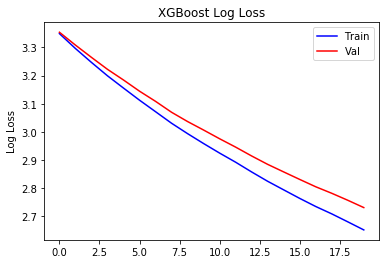

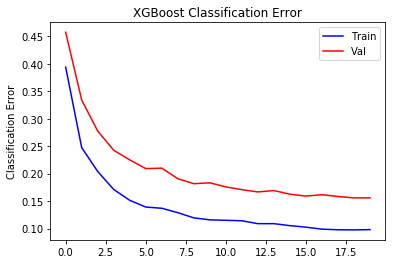

In [106]:
plot_results(xgb_model.evals_result())

Die erste Kurve zeigt uns die Log Loss Werte für den Trainings- und Validierungsdatensatz. Wie erwartet sinken beiden Werte. Das gleiche gilt für den Classification Error, auch wenn bei Epoche 20 die Kurve nur noch gering sinkt. Unser Modell ist stabil, es gibt kein <b>Overfitting</b>. Overfitting erkennt man, wenn die Validierungskurve nicht mehr sinken, sondern ab einem gewissen Punkt steigen würde. Wie wir das verhindern und frühzeitig erkennen können, sehen wir im nächsten Abschnitt.

### 9.5.3. Hyperparameteroptimierung von XGBoost <a class ="anchor" id="9-5-3"/>

Die Kurven aus dem vorherigen Abschnitt hatten gezeigt, dass unser Modell zwar stabil war, jedoch sanken vor allem die Log Loss Kurven noch. Dies ist ein Zeichen dafür, dass `n_estimator` zu klein war. Wir werden nun mit dem bereits aus Kapitel 7 bekannten <b>GridSearch</b>-Verfahren die Hyperparameter `max_depth` und `gamma` optimieren. `n_estimators` setzen wir zunächst auf `100`, die anderen Parameter verändern wir zunächst nicht. Da die Ausführung von GridSearch sehr lange dauert (in unserem Fall einmal eine Stunde und ein andermal fast 5 Stunden), müssen wir die Parameter mit Bedacht wählen und nicht zu viele Parameter auf einmal optimieren. Hier wählen wir zunächst blind die Parameter `max_depth` und `gamma` aus, da wir ja irgendwie beginnen müssen.

In [138]:
%%time
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': [3, 4, 5],
             'gamma': [0, 1, 5]}
ind_params = {'objective': 'multi:softmax',
              'learning_rate': 0.01, 
              'n_estimators': 100,
              'colsample_bytree': 0.3,
              'subsample': 0.8,  
              'random_state':42}

grid = GridSearchCV(XGBClassifier(**ind_params), cv_params, scoring = 'f1_micro', cv = 5, n_jobs = 6) 
grid.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

print(f"Der beste Score ist {str(np.around(grid.best_score_, decimals=4))}.")
print(f"Die besten Parameter waren folgende Parameter:\n {grid.best_params_}")

Der beste Score ist 0.9129.


NameError: name 'gridbest_params_' is not defined

In [140]:
print(f"Die besten Parameter waren folgende Parameter:\n {grid.best_params_}")

Die besten Parameter waren folgende Parameter:
 {'gamma': 0, 'max_depth': 5}


Die besten Parameter waren `gamma = 0` und `max_depth = 5`. Wir erhielten einen F1-score von 0.91. Bei `max_depth` wurde der maximale Wert unserer Testliste ausgewählt, weshalb wie diesen zunächst weiter optimieren, bevor wir andere Parameter optimieren. `max_depth` ist ein Parameter, der das Modell und somit GridSearch sehr verlangsamt, aber den F1-score des Modell auch sehr verbessern kann. 

In [144]:
%%time
cv_params = {'max_depth': [5, 6, 7, 8]}
ind_params = {'objective': 'multi:softmax',
              'learning_rate': 0.01,
              'gamma': 0,
              'n_estimators': 100,
              'colsample_bytree': 0.3,
              'subsample': 0.8,  
              'random_state':42}

grid = GridSearchCV(XGBClassifier(**ind_params), cv_params, scoring = 'f1_micro', cv = 5, n_jobs = 6) 
grid.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

print(f"Der beste Score ist {str(np.around(grid.best_score_, decimals=4))}.")
print(f"Die besten Parameter waren folgende Parameter:\n {grid.best_params_}")

Der beste Score ist 0.9152.
Die besten Parameter waren folgende Parameter:
 {'max_depth': 7}
CPU times: user 9min 58s, sys: 788 ms, total: 9min 58s
Wall time: 56min 12s


Der höchste Wert für `max_depth` hat den besten F1-Score erreicht. Wir wollen nun im Folgenden die Parameter `learning_rate` und `min_child_weight` anpassen. `min_child_weight` legt das Minimum der Gewichtssumme aller Beobachtungen fest, die bei einem Kindknoten vorausgesetzt werden. Dieser Parameter wird benutzt, um Overfitting zu kontrollieren. Eine weitere Neuerung ist der `early_stopping_parameter` bei der `fit`-Methode, welches Early Stopping behandelt. Wir haben hier den Wert auf "10" gesetzt, d.h. wenn der Log Loss nach 10 Trainingsdurchläufen keine Verbesserung erbracht hat, stoppt GridSearch und behandelt die nächste Parameterkombination.

<div class="alert alert-info">
<b>Exkurs:</b> Early Stopping
    
<b>Early Stopping</b> ist eine Technik um Overfitting zu verhindern. Ab einem gewissen Punkt des Trainings beginnt ein Modell, sich zu verschlechtern, was durch einen Anstieg des Log Loss Wertes erkannt werden kann. Early Stopping ist ein Verfahren, welches diesen Anstieg erkennen und das Training beenden soll. Es ist ein sehr einfaches aber effektives Verfahren. Zu beachten ist jedoch, dass eine Lernkurve nicht immer nur fällt, sondern auch zwischenzeitlich kurz ansteigen kann, um dann nach einigen Durchläufen wieder zu fallen. Das Abbruchkriterium für Early Stopping darf also nicht so hoch gesetzt werden, dass es bei der geringsten Schwankung das Training abbricht.
</div>

In [147]:
%%time
cv_params = {'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
             'min_child_weight' :[4, 5, 6]             
            }
ind_params = {'objective': 'multi:softmax',
              'max_depth': 7,
              'gamma': 0,
              'n_estimators': 250,
              'colsample_bytree': 0.3,
              'subsample': 0.8,  
              'random_state':42}

grid = GridSearchCV(XGBClassifier(**ind_params), cv_params, scoring = 'f1_micro', cv = 5, n_jobs = 6) 
grid.fit(X_train, y_train, early_stopping_rounds=10, 
         eval_metric=eval_metric, eval_set=eval_set, verbose=False)

print(f"Der beste Score ist {str(np.around(grid.best_score_, decimals=4))}.")
print(f"Die besten Parameter waren folgende Parameter:\n {grid.best_params_}")

Der beste Score ist 0.9056.
Die besten Parameter waren folgende Parameter:
 {'learning_rate': 0.05, 'min_child_weight': 4}
CPU times: user 18min 57s, sys: 2.64 s, total: 19min
Wall time: 4h 25min 4s


Dieser Durchlauf hat sehr lange gedauert mit ernüchterndem Ergebnis. Jeweils die beiden minimalen Parameter wurden gewählt und der F1-score hat sich verschlechtert. Wir testen nun noch kleiner Werte für die `learning_rate` und `min_child_weight`.

In [148]:
cv_params = {'learning_rate': [0.005, 0.01],
             'min_child_weight' :[1, 2]             
            }
ind_params = {'objective': 'multi:softmax',
              'max_depth': 7,
              'gamma': 0,
              'n_estimators': 250,
              'colsample_bytree': 0.3,
              'subsample': 0.8,  
              'random_state':42}

grid = GridSearchCV(XGBClassifier(**ind_params), cv_params, scoring = 'f1_micro', cv = 5, n_jobs = 6) 
grid.fit(X_train, y_train, early_stopping_rounds=10, 
         eval_metric=eval_metric, eval_set=eval_set, verbose=False)

print(f"Der beste Score ist {str(np.around(grid.best_score_, decimals=4))}.")
print(f"Die besten Parameter waren folgende Parameter:\n {grid.best_params_}")

Der beste Score ist 0.9188.
Die besten Parameter waren folgende Parameter:
 {'learning_rate': 0.005, 'min_child_weight': 1}


Tatsächlich hat sich der F1-Score wieder verbessert, wiederum waren jedoch die minimalen Werte die richtige Wahl. Niedriger als 1 können wird `min_child_weight` nicht wählen, dafür können wir einen niedrigeren Learning-Wert testen. Zudem werden wir nun auch ein weiteres Mal `max_depth` erhöhen.

In [150]:
%%time
cv_params = {'learning_rate': [0.00005, 0.0001, 0.005],
             'max_depth': [8, 9, 10]
            }
ind_params = {'objective': 'multi:softmax',
              'gamma': 0,
              'n_estimators': 250,
              'colsample_bytree': 0.3,
              'subsample': 0.8,
              'min_child_weight': 1,
              'random_state':42}

grid = GridSearchCV(XGBClassifier(**ind_params), cv_params, scoring = 'f1_micro', cv = 5, n_jobs = 6) 
grid.fit(X_train, y_train, early_stopping_rounds=10, 
         eval_metric=eval_metric, eval_set=eval_set, verbose=False)

print(f"Der beste Score ist {str(np.around(grid.best_score_, decimals=4))}.")
print(f"Die besten Parameter waren folgende Parameter:\n {grid.best_params_}")

Der beste Score ist 0.9194.
Die besten Parameter waren folgende Parameter:
 {'learning_rate': 0.005, 'max_depth': 10}
CPU times: user 33min 2s, sys: 3.1 s, total: 33min 5s
Wall time: 6h 3min 53s


Erneut konnten wir eine Verbesserung erzielen, wenn auch eine sehr kleine. Wird werden nun diese Parameter nehmen und ein finales Modell trainieren. `max_depth` werden wir jedoch verdoppeln, da auch bei diesem GridSearch Durchlauf die der Maximalwert des Parameters gewählt wurde. 

### 9.5.4. Das finale Modell <a class="anchor" id="9-5-4"/>

#### Korpus laden

In [3]:
import pandas as pd
corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv", index_col=0)

#### Aufteilung in Trainings- und Testdatensätze

In [9]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost.sklearn import XGBClassifier



vectorizer = TfidfVectorizer()

vector  = vectorizer.fit_transform(corpus["text"])
labels = LabelEncoder().fit_transform(corpus["category"])

X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    train_size=0.8,
                                                    shuffle=True,
                                                    random_state=42)

In [10]:
X_train_small = X_train[:3600]
y_train_small = y_train[:3600]
X_val = X_train[3600:]
y_val = y_train[3600:]

eval_set = [(X_train_small, y_train_small), (X_val, y_val)]
eval_metric = ["merror", "mlogloss"]

#### Visualisierungsfunktion

In [11]:
from matplotlib import pyplot

def plot_results(results):
    
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)
    
    # plot log loss
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], "b", label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], "r", label='Val')
    ax.legend()
    pyplot.ylabel('Log Loss')
    pyplot.title('XGBoost Log Loss')
    pyplot.show()

    # plot classification error
    fig, ax = pyplot.subplots()
    ax.plot(x_axis, results['validation_0']['merror'], "b", label='Train')
    ax.plot(x_axis, results['validation_1']['merror'], "r", label='Val')
    ax.legend()
    pyplot.ylabel('Classification Error')
    pyplot.title('XGBoost Classification Error')
    pyplot.show()

#### Das Modell

Neben der Erhöhung von `max_depth` werden wir auch `n_estimators` erhöhen. Diesen setzen wir zunächst auf 1000.

In [24]:
%%time
xgb_model = XGBClassifier(objective = "multi:softmax",
                          num_classes = len(np.unique(labels)),
                          learning_rate = 0.005,  
                          n_estimators = 1000,
                          max_depth = 20, 
                          colsample_bytree = 0.3,
                          subsample = 0.8,
                          gamma = 0,
                          verbosity = 1,
                          n_jobs = 6,
                          random_state = 42)


xgb_model.fit(X_train_small, 
              y_train_small, 
              early_stopping_rounds=10,
              eval_metric=eval_metric, 
              eval_set=eval_set, 
              verbose=False)

y_pred = xgb_model.predict(X_test)
xgb_f1 = f1_score(y_test, y_pred, average="micro")

CPU times: user 3h 47min 28s, sys: 1.6 s, total: 3h 47min 29s
Wall time: 37min 56s


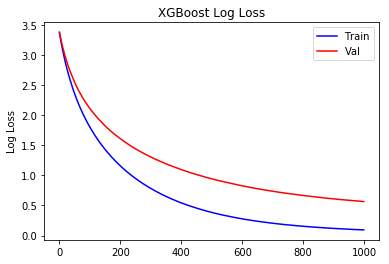

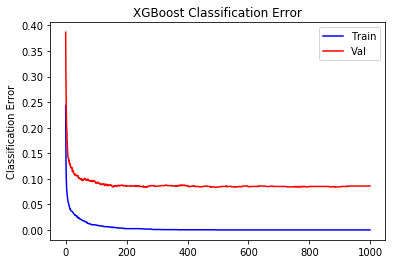


Der F1-score für die Klassifizierung mit XGBoost ist 0.926. 



In [25]:
plot_results(xgb_model.evals_result())
print("\nDer F1-score für die Klassifizierung mit XGBoost ist " + f"{str(np.around(xgb_f1, decimals=3))}. \n")

In einem letzten Versuch probieren wir, mit `n_estimators = 2000` noch einen besseren F1-score zu erreichen.

In [ ]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

import numpy as np
import matplotlib.pyplot as plt
import scipy

labels = LabelEncoder().fit_transform(corpus["category"])
vector  = TfidfVectorizer().fit_transform(corpus["text"])

X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    train_size=0.8,
                                                    random_state=42)

eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model = XGBClassifier(objective = "multi:softmax",
                          num_classes = len(np.unique(labels)),
                          learning_rate = 0.005,  
                          n_estimators = 100,
                          max_depth = 20, 
                          colsample_bytree = 0.3,
                          subsample = 0.8,
                          gamma = 0,
                          verbosity = 1,
                          n_jobs = 6,
                          random_state = 42)


xgb_model.fit(X_train, 
              y_train, 
              early_stopping_rounds=10,
              eval_metric=eval_metric, 
              eval_set=eval_set, 
              verbose=False)

y_pred = xgb_model.predict(X_test)
xgb_f1 = f1_score(y_test, y_pred, average="micro")

In [ ]:
plot_results(xgb_model.evals_result())
print("\nDer F1-score für die Klassifizierung mit XGBoost ist " + f"{str(np.around(xgb_f1, decimals=3))}. \n")

In [26]:
%%time
xgb_model = XGBClassifier(objective = "multi:softmax",
                          num_classes = len(np.unique(labels)),
                          learning_rate = 0.005,  
                          n_estimators = 2000,
                          max_depth = 20, 
                          colsample_bytree = 0.3,
                          subsample = 0.8,
                          gamma = 0,
                          verbosity = 1,
                          n_jobs = 6,
                          random_state = 42)


xgb_model.fit(X_train_small, 
              y_train_small, 
              early_stopping_rounds=10,
              eval_metric=eval_metric, 
              eval_set=eval_set, 
              verbose=False)

y_pred = xgb_model.predict(X_test)
xgb_f1 = f1_score(y_test, y_pred, average="micro")

CPU times: user 6h 20min 55s, sys: 9.28 s, total: 6h 21min 4s
Wall time: 1h 3min 42s


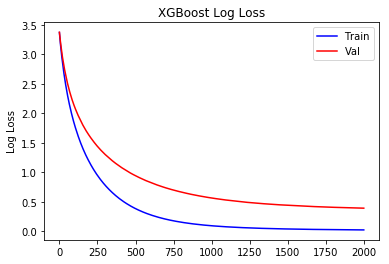

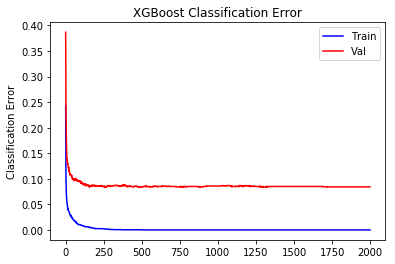


Der F1-score für die Klassifizierung mit XGBoost ist 0.924. 



In [27]:
plot_results(xgb_model.evals_result())
print("\nDer F1-score für die Klassifizierung mit XGBoost ist " + f"{str(np.around(xgb_f1, decimals=3))}. \n")

Tatsächlich ist der F1-score etwas weniger geworden.

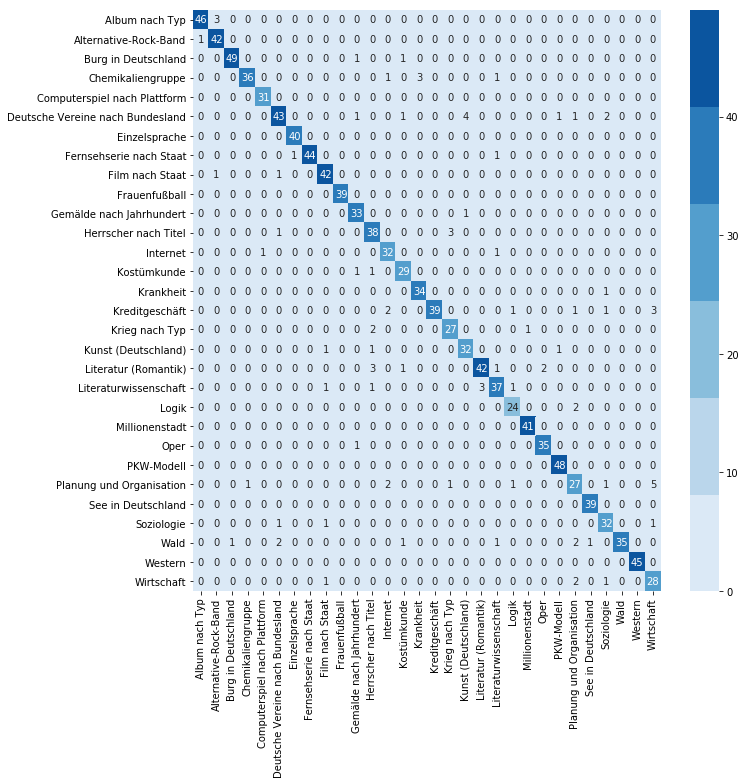

In [28]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix[:10] #verkürzte Darstellung, damit der Output nicht zu groß wird

import seaborn as sns
import matplotlib.pyplot as plt

# Die Original Kategorienbezeichnungen
classes = corpus["category"].drop_duplicates().tolist()

# Ein DataFrame mit den Kategorienbezeichnungen als Reihen und Spalten
cnf_df = pd.DataFrame(cnf_matrix, index=classes, columns=classes)
    
plt.figure(figsize=(11, 11))
sns.heatmap(cnf_df, annot=True, cmap=sns.color_palette("Blues"))
plt.tight_layout()

In [29]:
from sklearn.metrics import classification_report
classes = corpus["category"].drop_duplicates().tolist()
print(classification_report(y_test, y_pred, target_names=classes))

                                  precision    recall  f1-score   support

                  Album nach Typ       0.98      0.94      0.96        49
           Alternative-Rock-Band       0.91      0.98      0.94        43
             Burg in Deutschland       0.98      0.96      0.97        51
               Chemikaliengruppe       0.97      0.88      0.92        41
    Computerspiel nach Plattform       0.97      1.00      0.98        31
Deutsche Vereine nach Bundesland       0.90      0.81      0.85        53
                   Einzelsprache       0.98      1.00      0.99        40
         Fernsehserie nach Staat       1.00      0.96      0.98        46
                 Film nach Staat       0.91      0.95      0.93        44
                   Frauenfußball       1.00      1.00      1.00        39
        Gemälde nach Jahrhundert       0.89      0.97      0.93        34
            Herrscher nach Titel       0.83      0.90      0.86        42
                        Internet     

#### Fazit

Mit einem F1-score von 92.6 liefert XGBoost in unserem Fall schlechtere Werte als Logistic Regression oder SVM. Aber wir hatten doch zu Beginn des Abschnitts festgestellt, dass XGBoost angeblich eines der besten aktuellen Machine Learning Verfahren ist? Wieso liefert es dann nicht nach zahlreicher Hyperparameteroptimierung bessere Werte als die beiden anderen Verfahren? Bei einer Arbeit mit Machine Learning Klassifizierungsverfahren kann nie explizit vorausgesagt werden, ob Klassifizierungsverfahren A besser klassifiziert ist als Klassifizierungsverfahren B. Dies hängt von den einzelnen Datensätzen ab. Diese Tatsache sollte sich bewusst sein, wenn man mit Machine Learning Verfahren arbeitet. In den folgenden Deep Learning Kapiteln wird dies ähnlich sein. Eine gute Erklärung findet sich auch bei <a href="https://stats.stackexchange.com/questions/394705/classification-xgboost-vs-logistic-regression">StackExchange</a>. Trotzdem sollte man sich bewusst sein, dass XGBoost zahlreiche Machine Learning Wettbewerbe gewonnen hat. In seinem Buch "Deep Learning with Keras", welches wir in den nächsten Kapiteln behandeln werdne, meint der Autor Francois Chollet, dass für die Anwendung von Machine Learning Verfahren XGBoost und die Neuronalen Netze des Deep Learning heutzutage die erfolgreichsten Verfahren sind (siehe CHOLLET, Deep Learning with Keras, New York 2018, Kapitel 1.2.7).

## 9.6. Mögliche Fehler <a class="anchor" id="9-6"/>

- XGBoost: Mein Modell läuft sehr langsam, obwohl ich `n_estimators` niedrig gesetzt habe → ist `n_jobs` auf die eigenen CPUs angepasst? Standardmäßig wird nur ein Kern benutzt, dies kann um einiges länger dauern als bei der Benutzung von mehreren Kernen.
- XGBoost: Ich möchte Multiclass Klassifizierung anwenden, mein Modell scheint jedoch binäre Klassifizierung zu benutzen → Standardmäßig ist `objective='binary:logistic'` gesetzt. Für eine Multiclass Klassifizierung muss `objective = 'multi:softmax'` oder `objective = 'multi:softprob'` sein.